# Using Convolutional Neural Networks

Welcome to the first week of the first deep learning certificate! We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning.

## Basic setup

There isn't too much to do to get started - just a few simple configuration steps.

This shows plots in the web page itself - we always wants to use this when using jupyter notebook:

In [1]:
from __future__ import division, print_function

%matplotlib inline

Define path to data: (It's a good idea to put it in a subdirectory of your notebooks folder, and then exclude that directory from git control by adding it to .gitignore.)

In [2]:
path = "convbattle/"
#path = "data/dogscats/sample/"

A few basic libraries that we'll need for the initial exercises:

In [3]:
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

We have created a file most imaginatively called 'utils.py' to store any little convenience functions we'll want to use. We will discuss these as we use them.

In [4]:
# check that ~/.keras/keras.json is set for Theano and includes "image_data_format": "channels_first"
from importlib import reload  # Python 3
import utils; reload(utils)
from utils import plots

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
Using TensorFlow backend.


In [5]:
""" patch input matrix shape errors

1. modify def ConvBlock in vgg16.py
    def ConvBlock(self, layers, filters):
        model = self.model
        for i in range(layers):
            model.add(ZeroPadding2D((1, 1)))
            model.add(Conv2D(filters, kernel_size=(3, 3), activation='relu'))  # Keras2
        ### >>> replace following line
        ### model.add(MaxPooling2D((2, 2), strides=(2, 2)))
        ### >>> by this one
        model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
        
2. set keras image_dim_ordering = 'th'

"""

from keras import backend as K
K.set_image_dim_ordering('th')

# Use a pretrained VGG model with our **Vgg16** class

Our first step is simply to use a model that has been fully created for us, which can recognise a wide variety (1,000 categories) of images. We will use 'VGG', which won the 2014 Imagenet competition, and is a very simple model to create and understand. The VGG Imagenet team created both a larger, slower, slightly more accurate model (*VGG  19*) and a smaller, faster model (*VGG 16*). We will be using VGG 16 since the much slower performance of VGG19 is generally not worth the very minor improvement in accuracy.

We have created a python class, *Vgg16*, which makes using the VGG 16 model very straightforward. 

In [6]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
#batch_size = 1
#batch_size = 4
batch_size = 64

In [7]:
# Import our class, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [8]:
vgg = Vgg16()
# Grab a few images at a time for training and validation.
# NB: They must be in subdirectories named based on their category
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)

Found 2378 images belonging to 2 classes.
Found 792 images belonging to 2 classes.


Found 2378 images belonging to 2 classes.


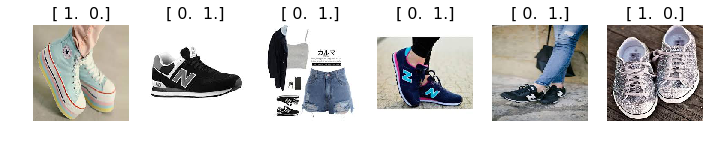

In [9]:
batches = vgg.get_batches(path+'train', batch_size=6)
imgs,labels = next(batches)
plots(imgs, titles=labels)

In [10]:
vgg.predict(imgs, True)

(array([ 0.2104,  0.184 ,  0.3813,  0.0997,  0.2216,  0.5915], dtype=float32),
 array([452, 678, 841, 597,  98, 714]),
 ['bonnet',
  'neck_brace',
  'sweatshirt',
  'holster',
  'red-breasted_merganser',
  'pick'])

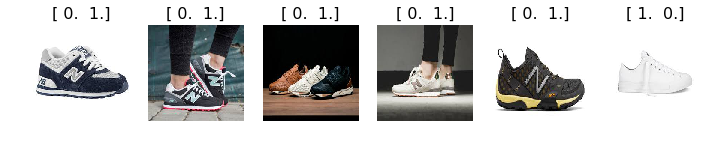

In [11]:
imgs,labels = next(batches)
plots(imgs, titles=labels)

In [12]:
vgg.predict(imgs, True)

(array([ 0.3887,  0.1719,  0.1227,  0.204 ,  0.4013,  0.0627], dtype=float32),
 array([615, 655, 763, 999, 597, 596]),
 ['knee_pad', 'miniskirt', 'revolver', 'toilet_tissue', 'holster', 'hatchet'])

The category indexes are based on the ordering of categories used in the VGG model - e.g here are the first four:

In [13]:
vgg.classes[:4]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark']

In [14]:
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, batch_size, nb_epoch=1)

Found 2378 images belonging to 2 classes.
Found 792 images belonging to 2 classes.
Epoch 1/1
38/38 [==============================] - 91s - loss: 0.9866 - acc: 0.6674 - val_loss: 0.6722 - val_acc: 0.7288


the validation accuracy is not pretty good, let's try some more training, but beware of overfitting ^^

In [15]:
vgg.fit(batches, val_batches, batch_size, nb_epoch=5)

Epoch 1/5
38/38 [==============================] - 71s - loss: 0.7208 - acc: 0.7605 - val_loss: 0.6963 - val_acc: 0.7273
Epoch 2/5
38/38 [==============================] - 71s - loss: 0.6429 - acc: 0.7786 - val_loss: 0.5585 - val_acc: 0.7685
Epoch 3/5
38/38 [==============================] - 71s - loss: 0.6388 - acc: 0.7757 - val_loss: 0.6902 - val_acc: 0.7308
Epoch 4/5
38/38 [==============================] - 71s - loss: 0.5693 - acc: 0.7980 - val_loss: 0.6354 - val_acc: 0.7541
Epoch 5/5
38/38 [==============================] - 71s - loss: 0.4996 - acc: 0.8215 - val_loss: 0.6276 - val_acc: 0.7376


##### to discuss in studygroup : val_acc is stable while acc gets better :
1. looks like the beginning of overfitting :-|
1. how to deal with stable val_acc ?

From here we can use exactly the same steps as before to look at predictions from the model.

Found 2378 images belonging to 2 classes.


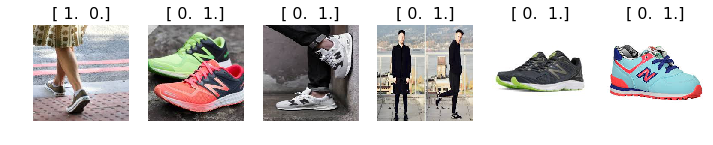

In [16]:
batches = vgg.get_batches(path+'train', batch_size=6)
imgs,labels = next(batches)
plots(imgs, titles=labels)

In [17]:
vgg.predict(imgs, True)

(array([ 0.9976,  0.994 ,  0.9745,  0.9584,  0.9917,  0.9592], dtype=float32),
 array([0, 1, 1, 1, 1, 1]),
 ['converse',
  'newbalance',
  'newbalance',
  'newbalance',
  'newbalance',
  'newbalance'])

Found 2378 images belonging to 2 classes.


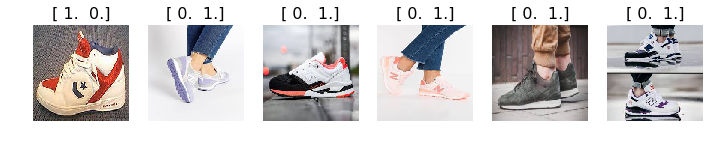

In [18]:
batches = vgg.get_batches(path+'train', batch_size=6)
imgs,labels = next(batches)
plots(imgs, titles=labels)

In [19]:
vgg.predict(imgs, True)

(array([ 0.5673,  0.9759,  0.9946,  0.8872,  0.99  ,  0.9972], dtype=float32),
 array([0, 1, 1, 1, 1, 1]),
 ['converse',
  'newbalance',
  'newbalance',
  'newbalance',
  'newbalance',
  'newbalance'])

Found 2378 images belonging to 2 classes.


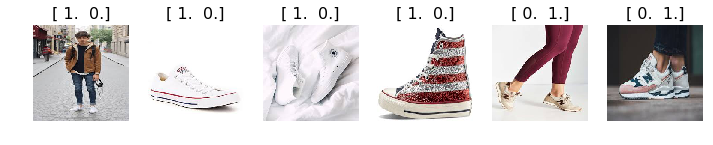

In [20]:
batches = vgg.get_batches(path+'train', batch_size=6)
imgs,labels = next(batches)
plots(imgs, titles=labels)

In [21]:
vgg.predict(imgs, True)

(array([ 0.7326,  0.9754,  0.7688,  0.9998,  0.9118,  0.9893], dtype=float32),
 array([0, 0, 0, 0, 1, 1]),
 ['converse', 'converse', 'converse', 'converse', 'newbalance', 'newbalance'])

### Notice the prediction %
when below 0.9 and predict converse class : should interpreted like a confusing sample

##### an other to show prediction

The VGG model returns 1,000 probabilities for each image, representing the probability that the model assigns to each possible imagenet category for each image. By finding the index with the largest probability (with *np.argmax()*) we can find the predicted label.

In [39]:
def pred_batch(m,imgs):
    preds = m.model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(m.classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], m.classes[idx]))

In [40]:
pred_batch(vgg,imgs)

Shape: (6, 2)
First 5 classes: ['converse', 'newbalance']
First 5 probabilities: [ 0.7326  0.2674]

Predictions prob/class: 
  0.7326/converse
  0.9754/converse
  0.7688/converse
  0.9998/converse
  0.9118/newbalance
  0.9893/newbalance


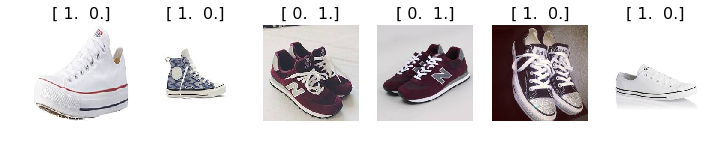

In [41]:
imgs,labels = next(batches)

# This shows the 'ground truth'
plots(imgs, titles=labels)

In [43]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']
First 5 probabilities: [  3.2599e-07   1.7466e-06   6.1671e-07   1.7458e-07   9.6081e-08]

Predictions prob/class: 
  0.5597/Persian_cat
  0.1442/standard_poodle
  0.3495/Boston_bull
  0.3960/Boston_bull


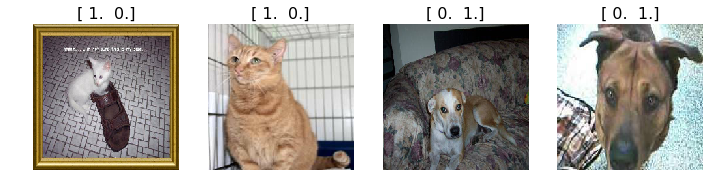

In [44]:
imgs,labels = next(batches)

# This shows the 'ground truth'
plots(imgs, titles=labels)

In [43]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']
First 5 probabilities: [  3.2599e-07   1.7466e-06   6.1671e-07   1.7458e-07   9.6081e-08]

Predictions prob/class: 
  0.5597/Persian_cat
  0.1442/standard_poodle
  0.3495/Boston_bull
  0.3960/Boston_bull
